In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [2]:
from google.colab import files
file = files.upload()
df = pd.read_csv("bank-full.csv", sep=';') 
df.head()

Saving bank-full.csv to bank-full.csv


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Check dataset info and see variable types
df.info()
# In our dataset, there are 16 variables, including 7 numerical variables and 9 categorical variables.
# There doesn't seem to be any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Data Exploration and Visualization

## Preliminary Exploration

In [ ]:
# Target variable
df['y'].value_counts()
# We found that the dataset is imbalanced.
# The percentage of 'yes' account for 11.69%, so in the next phase, we should do something to change the imbalanced dataset.

0    39922
1     5289
Name: y, dtype: int64

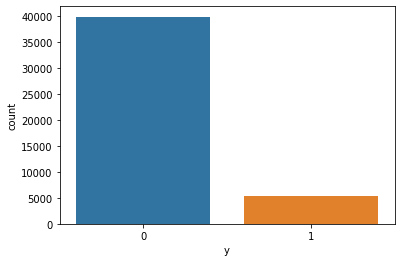

In [ ]:
# Visualize the imbalance
sns.countplot(x = df["y"])

In [ ]:
# Run summary statistics on each variable
df.groupby('y').describe()

age                                    ... previous                      
       count       mean        std   min   25%  ...      min  25%  50%  75%    max
y                                               ...                               
no   39922.0  40.838986  10.172662  18.0  33.0  ...      0.0  0.0  0.0  0.0  275.0
yes   5289.0  41.670070  13.497781  18.0  31.0  ...      0.0  0.0  0.0  1.0   58.0

[2 rows x 56 columns]

In [ ]:
# When loading the data, we found some variables with a category of "unknown"
# Check these variables for the percentages of unknown so that we can either impute or drop
result = {
    col: df.loc[df[col]=='unknown',col].count()
    for col in df.select_dtypes(include=['object']).drop('y',axis=1).columns
}
print(result)

{'job': 288, 'marital': 0, 'education': 1857, 'default': 0, 'housing': 0, 'loan': 0, 'contact': 13020, 'month': 0, 'poutcome': 36959}


In [ ]:
print("The percentages of \"unknown\" values in each categorical variables")
for i in result.keys():
  print(i, "{:.2%}".format(result.get(i)/len(df)))

The percentages of "unknown" values in each categorical variables
job 0.64%
marital 0.00%
education 4.11%
default 0.00%
housing 0.00%
loan 0.00%
contact 28.80%
month 0.00%
poutcome 81.75%


In [ ]:
# Th attribute "duration" will highly affects the output target.(eg, if duration = '0', then y = '0'; >0 then y= "1")
# Output below shows the number of observation with duration > 0 and y="yes" equals
# to the total number of "yes" observations in the dataset.
df[(df['duration'] > 0) & (df['y']=='yes')].shape[0]

5289

In [3]:
# For convenience, encode outcome variable as 0/1 binary variable
# Yes - 1; No- 0
df['y'] = df['y'].map({'yes':1, 'no':0})

In [ ]:
# Check the skewness of numerical variables
# We should consider changing highly skewed variables before model building
df.skew()

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
y            2.383480
dtype: float64

## Visualization

### Categorical Variables

Visualizing cross-tab comparisons of each category of every categorical data with respect to the outcome variable(y=0/1)

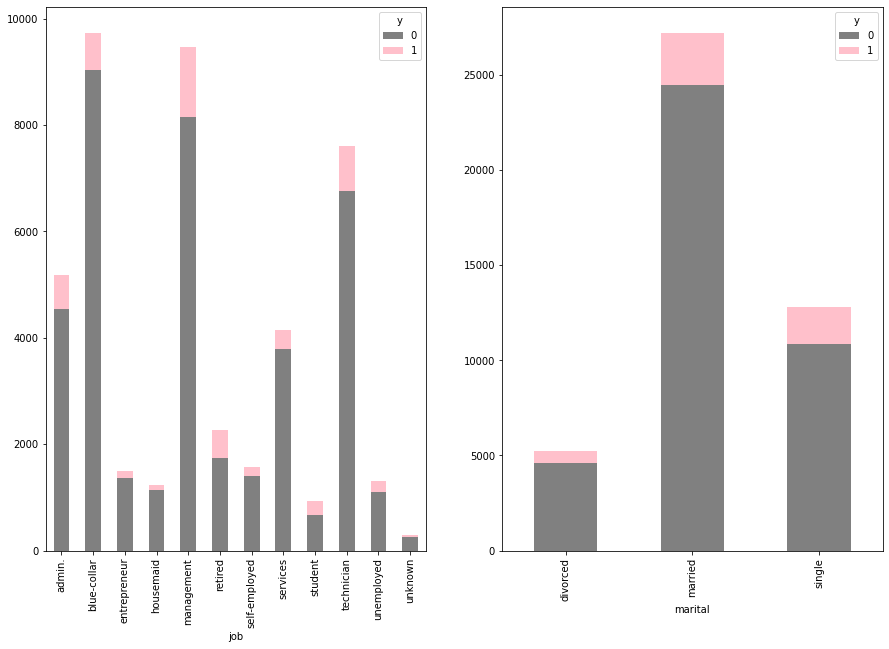

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax1= plt.subplot(121)
pd.crosstab(df['job'],df['y']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(122)
pd.crosstab(df['marital'],df['y']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)

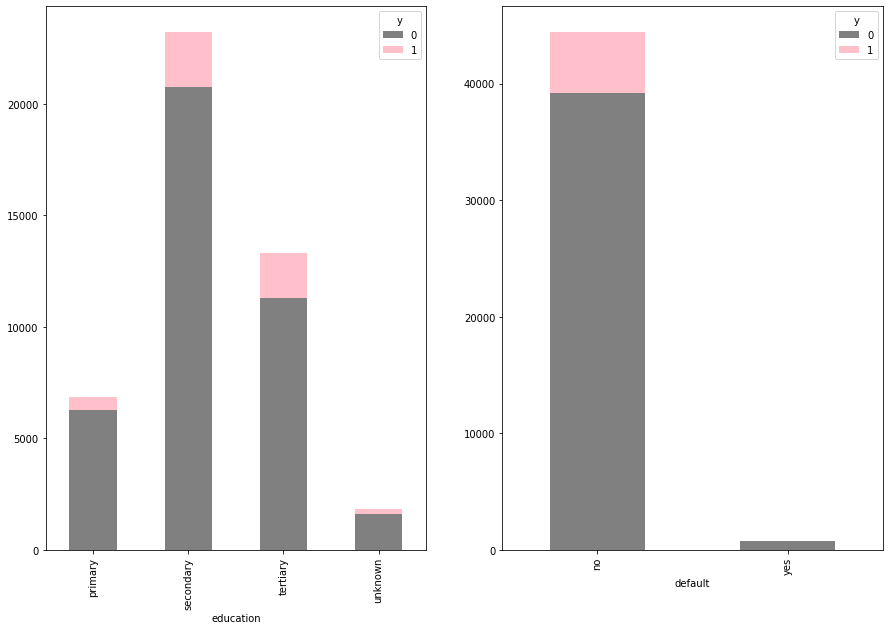

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax1= plt.subplot(121)
pd.crosstab(df['education'],df['y']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(122)
pd.crosstab(df['default'],df['y']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)

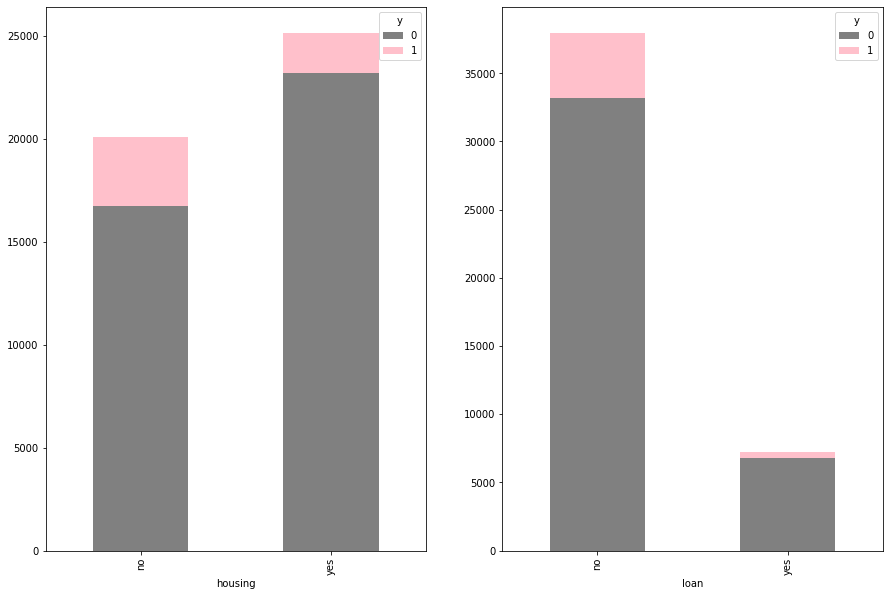

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
ax1= plt.subplot(121)
pd.crosstab(df['housing'],df['y']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(122)
pd.crosstab(df['loan'],df['y']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)

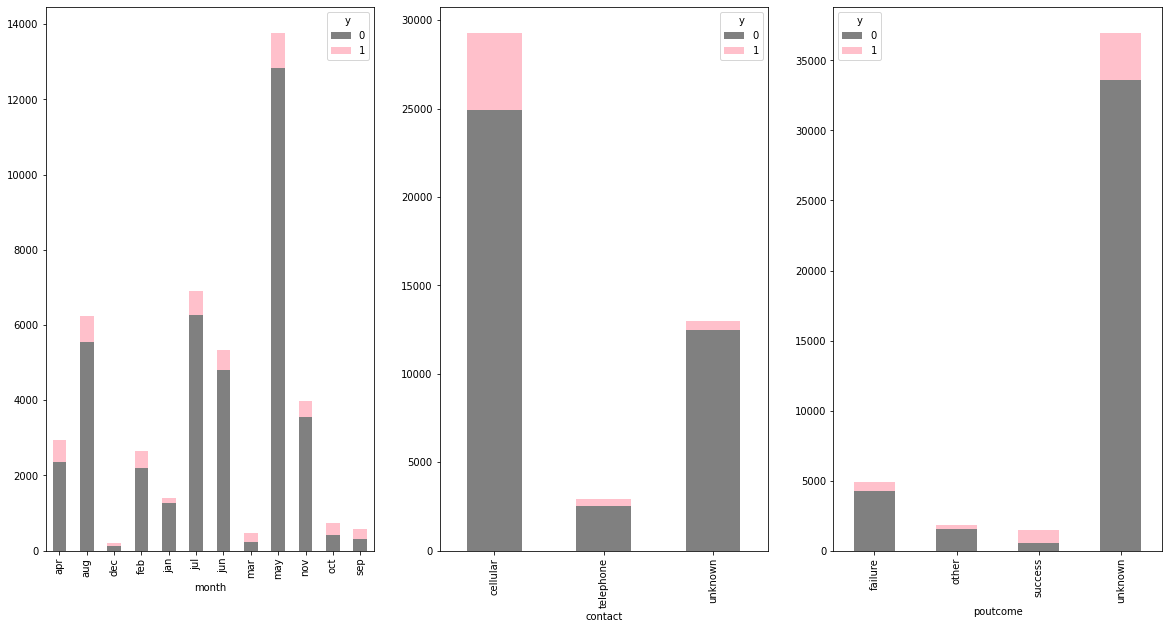

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax1= plt.subplot(131)
pd.crosstab(df['month'],df['y']).plot(kind = 'bar', stacked = True, color = ['Gray', 'pink'],ax=ax1)
ax2= plt.subplot(132)
pd.crosstab(df['contact'],df['y']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax2)
ax3= plt.subplot(133)
pd.crosstab(df['poutcome'],df['y']).plot(kind = 'bar', stacked = True,  color = ['Gray', 'pink'],ax=ax3)

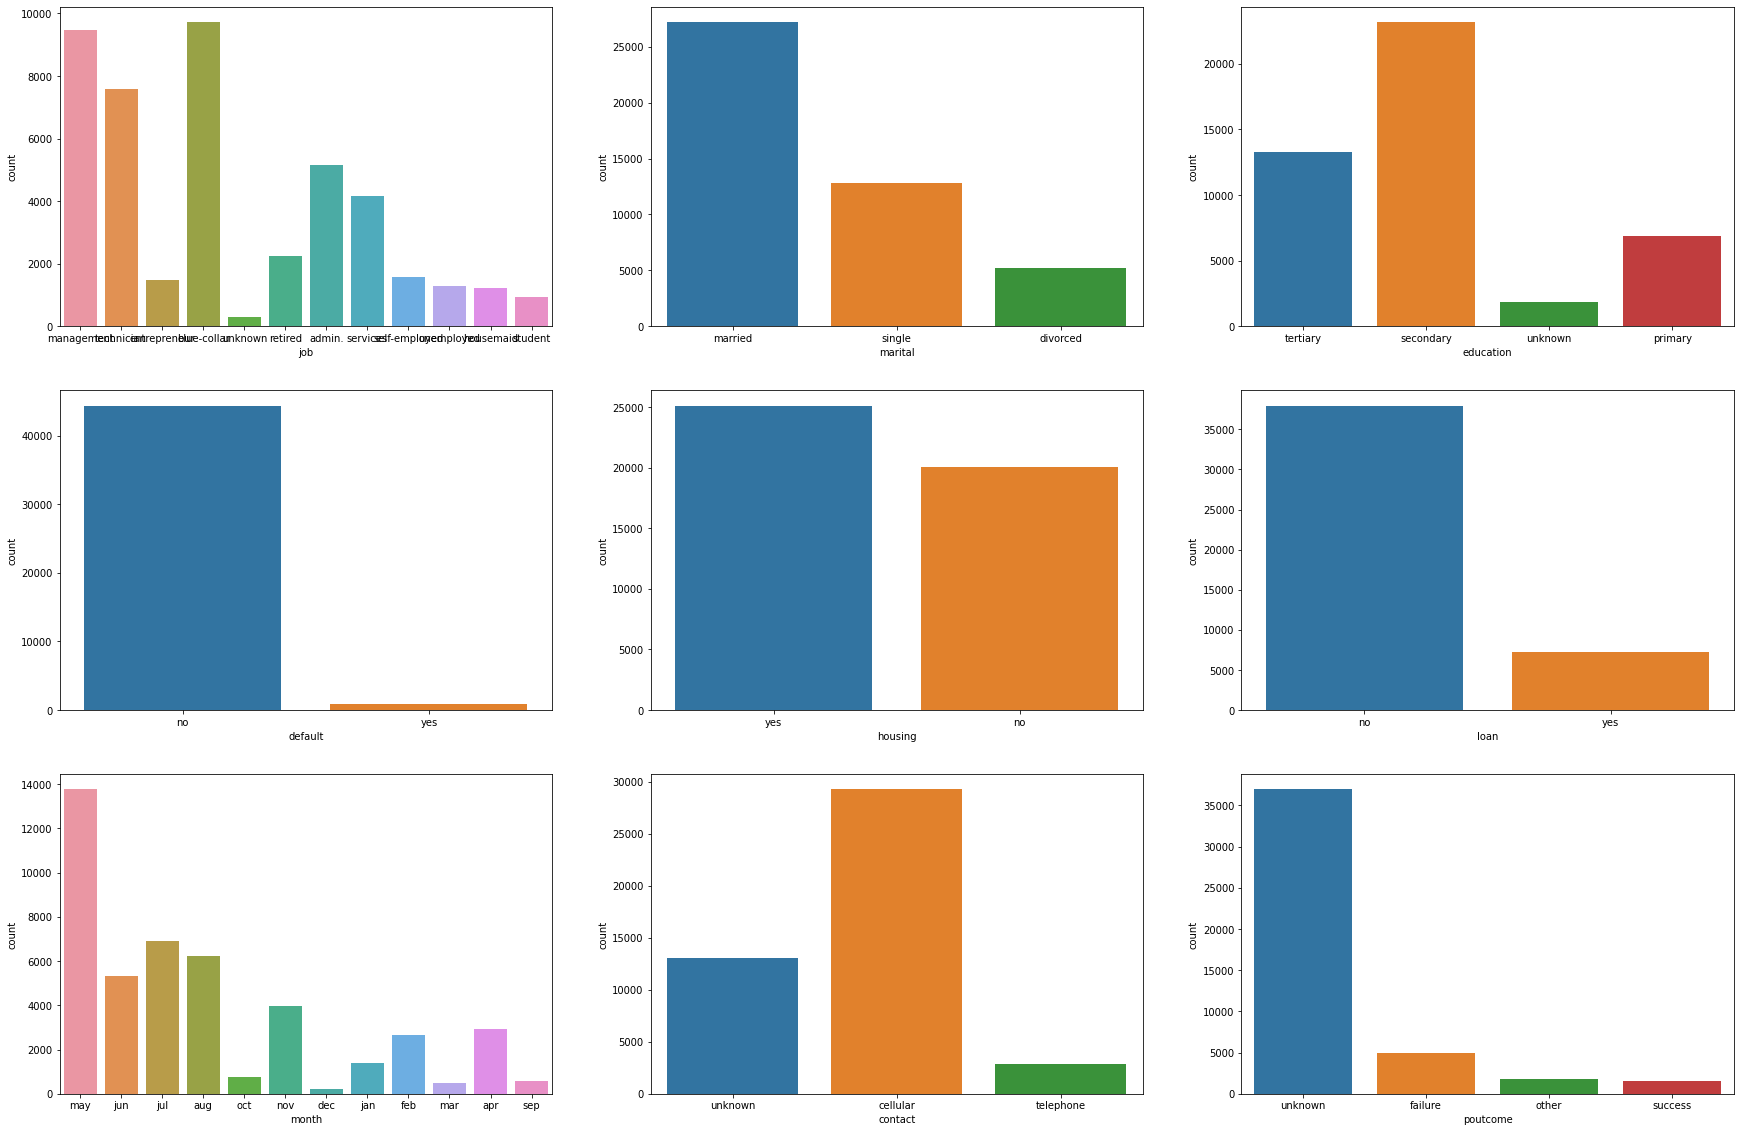

In [ ]:
# Bar plot of every category for each variable

fig, ax = plt.subplots(3,3,figsize=(30,20))
ax1= plt.subplot(331)
sns.countplot(x = df['job'],ax=ax1)
ax2= plt.subplot(332)
sns.countplot(x = df['marital'],ax=ax2)
ax3= plt.subplot(333)
sns.countplot(x = df['education'],ax=ax3)
ax4= plt.subplot(334)
sns.countplot(x = df['default'],ax=ax4)
ax5= plt.subplot(335)
sns.countplot(x = df['housing'],ax=ax5)
ax6= plt.subplot(336)
sns.countplot(x = df['loan'],ax=ax6)
ax7= plt.subplot(337)
sns.countplot(x = df['month'],ax=ax7)
ax8= plt.subplot(338)
sns.countplot(x = df['contact'],ax=ax8)
ax9= plt.subplot(339)
sns.countplot(x = df['poutcome'],ax=ax9)



### Numerical Variables

Ignored "duration" in this part because we'll need to drop it anyways.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f263fc61190>,
      dtype=object)

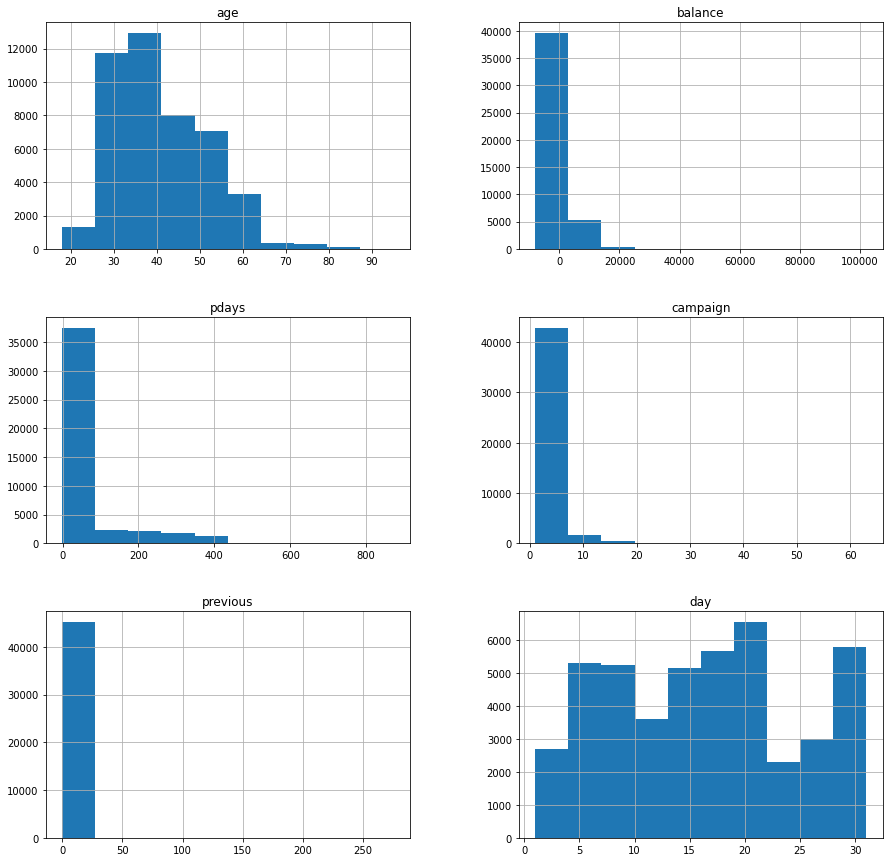

In [ ]:
num_col = ['age','balance','pdays','campaign','previous','day']
df.hist(num_col,figsize = (15,15))

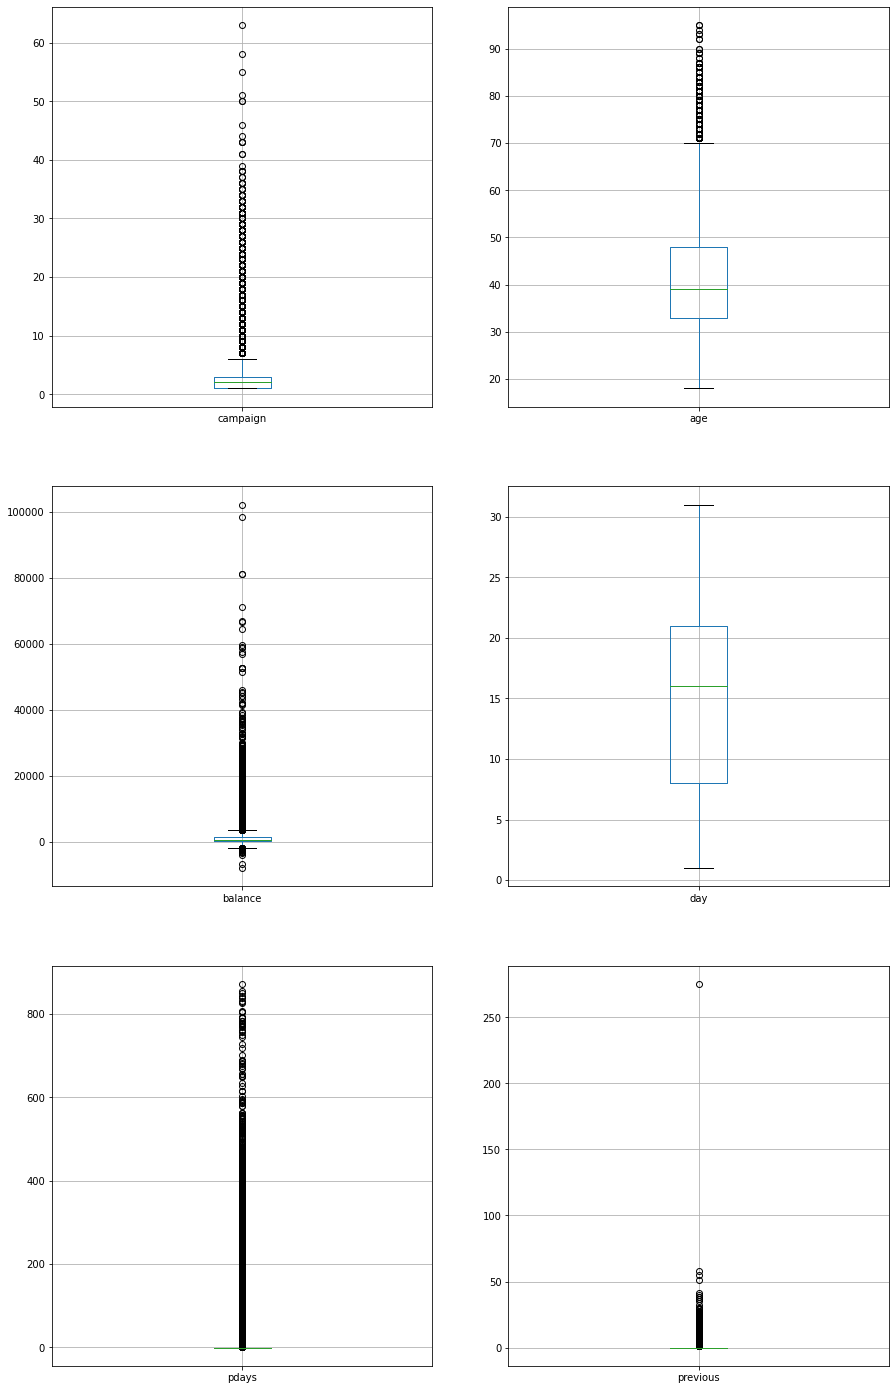

In [ ]:
# Boxplots
fig, ax = plt.subplots(3,2,figsize=(15,25))
ax1= plt.subplot(321)
df.boxplot(column = ['campaign'],ax=ax1)
ax2= plt.subplot(322)
df.boxplot(column = ['age'],ax=ax2)
ax3= plt.subplot(323)
df.boxplot(column = ['balance'],ax=ax3)
ax4= plt.subplot(324)
df.boxplot(column = ['day'],ax=ax4)
ax5= plt.subplot(325)
df.boxplot(column = ['pdays'],ax=ax5)
ax6= plt.subplot(326)
df.boxplot(column = ['previous'],ax=ax6)

# Data Preprocessing

Dropping variables

In [4]:
# duration for reasons stated previously
# drop "contact" and "poutcome" because the "unknown" proportions are too high
drop_cols = ['duration','poutcome','contact']
df.drop(labels=drop_cols, axis = 1,inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,1,-1,0,0
1,44,technician,single,secondary,no,29,yes,no,5,may,1,-1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1,-1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,1,-1,0,0
4,33,unknown,single,unknown,no,1,no,no,5,may,1,-1,0,0


In [5]:
df.replace('unknown',np.NaN, inplace = True)

Imputing "unknown" values 

In [6]:
# Impute "unknown" values for "job" and "education"
# So 'Secondary' education is the majority class
df['education'].value_counts() 

secondary    23202
tertiary     13301
primary       6851
Name: education, dtype: int64

In [7]:
# "blue-collar" is the majority class
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64

In [8]:
df['education'].fillna('secondary', inplace = True)
df['job'].fillna('blue-collar', inplace = True)

Changing skewness for variables with only positive values

In [9]:
# changing skewness using boxcox transformation
import scipy.stats as st
df['age'],i = st.boxcox(df['age']+1)
#df['balance'],i = st.boxcox(df['balance']+1)
df['day'],i = st.boxcox(df['day']+1)
df['campaign'],i = st.boxcox(df['campaign']+1)
#df['pdays'],i = st.boxcox(df['pdays']+1)
df['previous'],i = st.boxcox(df['previous']+1)

Scale numerical data and creaty dummy variables for categorical data

In [10]:
num_cols = [col for col in df.drop('y',axis=1).select_dtypes(['int64','float64'])]
cat_cols = [col for col in df.select_dtypes(['object'])]
print(num_cols,cat_cols)

['age', 'balance', 'day', 'campaign', 'pdays', 'previous'] ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']


In [ ]:
# Check distributions again
#df.hist(column = num_cols, figsize = (20,20))

In [11]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(df[num_cols])
num_df = pd.DataFrame(X_minmax,columns=num_cols)
num_df.head()

,age,balance,day,campaign,pdays,previous
0,0.731404,0.092259,0.195769,0.0,0.0,0.0
1,0.570729,0.073067,0.195769,0.0,0.0,0.0
2,0.395437,0.072822,0.195769,0.0,0.0,0.0
3,0.609772,0.086476,0.195769,0.0,0.0,0.0
4,0.395437,0.072812,0.195769,0.0,0.0,0.0


In [ ]:
# num_df.hist(column = num_cols,figsize = (20,20))

In [12]:
cat_df = pd.get_dummies(df[cat_cols])
cat_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [13]:
# After scaling and creating dummies, combine dataframes
df_new = pd.concat([num_df, cat_df,df['y']],axis=1)
df_new.head()

,age,balance,day,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,0.731404,0.092259,0.195769,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.570729,0.073067,0.195769,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.395437,0.072822,0.195769,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.609772,0.086476,0.195769,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.395437,0.072812,0.195769,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [14]:
#Separate the predictors and response
X = df_new.loc[:, df_new.columns !='y']
y = df_new.loc[:, df_new.columns == 'y']

# Feature Selection and Dimension Reduction 

Besides variables in preprocessing stage, we can try further feature selection. (In the appendix, we also included PCA implementation but since it's not significantly improving the performance and it loses explainability, we will not include this method formally.

In [15]:
#Feature selection using Backward Elimination based on p values of variables
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE) 

['age', 'balance', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_single', 'education_primary', 'education_secondary', 'housing_no', 'loan_no', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']


In [16]:
len(selected_features_BE)

31

In [ ]:
# keep a copy of these features 
be_selected = ['age', 'balance', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management',
               'job_self-employed', 'job_services', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_single', 'education_primary', 'education_secondary', 
               'housing_no', 'loan_no', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
               'month_sep']

# Model Exploration and Selection

Oversample the training dataset only so that the information from test data won't be leaked to training the models.

Our oversampling strategy is to use SMOTETomek function - this method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove data from the majority class that is the closest with the minority class data. It not only oversamples, but also "cleans" the data a little bit. This will help the model to learn the minority class better.

In [17]:
from imblearn.combine import SMOTETomek
os = SMOTETomek(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y = pd.DataFrame(data=os_data_y)
print("length of oversampled data is ",len(os_data_X))
print("Number of Subscribers in oversampled data",len(os_data_y[os_data_y['y']==1]))
print("Number of Non-Subscribers in oversampled data",len(os_data_y[os_data_y['y']==0]))

length of oversampled data is  54410
Number of Subscribers in oversampled data 27205
Number of Non-Subscribers in oversampled data 27205


## Baseline models with default parameters

In [18]:
# Initialize models that we are going to build
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=0)

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

from sklearn.naive_bayes import GaussianNB
nbs = GaussianNB()

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,random_state=0)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)

In [ ]:
# Logistic Regression
logit.fit(os_data_X, os_data_y)
y_pred_logit = logit.predict(X_test)
print("Accuracy of logistic regression classifier on testing set is: {:.2f}".format(logit.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_logit)))

Accuracy of logistic regression classifier on testing set is: 0.80
The AUROC value for testing set is: 0.68


In [ ]:
print(classification_report(y_test,y_pred_logit))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     11969
           1       0.29      0.52      0.38      1595

    accuracy                           0.80     13564
   macro avg       0.61      0.68      0.63     13564
weighted avg       0.85      0.80      0.82     13564



In [ ]:
# Decision Trees
tree.fit(os_data_X, os_data_y)
y_pred_tree = tree.predict(X_test)
print("Accuracy of Decision Tree Classifier on testing set is: {:.2f}".format(tree.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_tree)))

Accuracy of Decision Tree Classifier on testing set is: 0.78
The AUROC value for testing set is: 0.58


In [ ]:
# Naive Bayes
nbs.fit(os_data_X, os_data_y)
y_pred_nbs = nbs.predict(X_test)
print("Accuracy of Decision Tree Classifier on testing set is: {:.2f}".format(nbs.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_nbs)))

Accuracy of Decision Tree Classifier on testing set is: 0.82
The AUROC value for testing set is: 0.65


In [ ]:
# KNN 
knn.fit(os_data_X, os_data_y)
y_pred_knn = knn.predict(X_test)
print("Accuracy of Decision Tree Classifier on testing set is: {:.2f}".format(knn.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_knn)))

Accuracy of Decision Tree Classifier on testing set is: 0.76
The AUROC value for testing set is: 0.64


In [ ]:
# Random Forest
rfc.fit(os_data_X, os_data_y)
y_pred_rfc = rfc.predict(X_test)
print("Accuracy of Decision Tree Classifier on testing set is: {:.2f}".format(rfc.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_rfc)))

Accuracy of Decision Tree Classifier on testing set is: 0.84
The AUROC value for testing set is: 0.64


In [ ]:
print(confusion_matrix(y_test,y_pred_rfc))
print(classification_report(y_test,y_pred_rfc))

[[10782  1187]
 [  995   600]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     11969
           1       0.34      0.38      0.35      1595

    accuracy                           0.84     13564
   macro avg       0.63      0.64      0.63     13564
weighted avg       0.85      0.84      0.84     13564



## Hyperparameter tuning and cross-validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
# Hyperparameter Tuning of Random Forest

rfc_tunned=RandomForestClassifier(n_estimators=100,random_state=0)
params={'n_estimators':sp_randint(1,1200),
        'max_features':sp_randint(1,18),
        'max_depth': sp_randint(1,60),
        'min_samples_split':sp_randint(2,40),
        'min_samples_leaf':sp_randint(2,20),
        'criterion':['gini','entropy']}

search_rfc=RandomizedSearchCV(rfc_tunned,params,cv=3,scoring='roc_auc',n_jobs=-1,random_state=0)

search_rfc.fit(os_data_X, os_data_y)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1fbded6fd0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1fbdecf610>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1fbdef9910>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1fbded6e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1fbded6a90>},
                   random_state=0, scoring='roc_auc')

In [ ]:
search_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 33,
 'max_features': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 13,
 'n_estimators': 883}

In [20]:
# Record the output so we don't have to run randomized search everytime 
best_params = {'criterion': 'entropy',
 'max_depth': 33,
 'max_features': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 13,
 'n_estimators': 883}

In [21]:
# Using tuned parameters, check how the performance improved
rfc_tuned=RandomForestClassifier(**best_params,random_state=0)
rfc_tuned.fit(os_data_X, os_data_y)
y_pred_rfc_tuned = rfc_tuned.predict(X_test)
print("Accuracy of Decision Tree Classifier on testing set is: {:.2f}".format(rfc_tuned.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_rfc_tuned)))

Accuracy of Decision Tree Classifier on testing set is: 0.87
The AUROC value for testing set is: 0.68


In [ ]:
print(confusion_matrix(y_test,y_pred_rfc_tuned))
print(classification_report(y_test,y_pred_rfc_tuned))

[[10942  1027]
 [  940   655]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     11969
           1       0.39      0.41      0.40      1595

    accuracy                           0.85     13564
   macro avg       0.66      0.66      0.66     13564
weighted avg       0.86      0.85      0.86     13564



In [ ]:
knn_tunned = KNeighborsClassifier()

params={'n_neighbors':sp_randint(1,20),'p':sp_randint(1,3)}

search_knn = RandomizedSearchCV(knn_tunned,params,cv=3,scoring='roc_auc',n_jobs=-1,random_state=0)
search_knn.fit(os_data_X, os_data_y)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9864545190>,
                                        'p': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9864545690>},
                   random_state=0, scoring='roc_auc')

In [ ]:
search_knn.best_params_

{'n_neighbors': 2, 'p': 1}

In [22]:
knn_params = {'n_neighbors': 2, 'p': 1}

In [23]:
knn_tuned = KNeighborsClassifier(**knn_params)

In [24]:
knn_tuned.fit(os_data_X, os_data_y)
y_pred_knn_tuned = knn_tuned.predict(X_test)
print("Accuracy of KNN Classifier on testing set is: {:.2f}".format(knn_tuned.score(X_test, y_test)))
print("The AUROC value for testing set is: {:.2f}".format(roc_auc_score(y_test, y_pred_knn_tuned)))

Accuracy of KNN Classifier on testing set is: 0.83
The AUROC value for testing set is: 0.60


# Performance Evaluation

Using 10-fold cross-validation on training data and to compare the performances of each model, using mutiple performance metrics and check for the best one. 

In [26]:
# For creating a stacked model performance evaluation chart
models=[]
models.append(('Logistic',logit))
models.append(('Decision Tree',tree))
models.append(('Naive Bayes',nbs))
models.append(('Random Forest',rfc))
models.append(('Random Forest Tuned',rfc_tuned))
models.append(('KNN',knn))
models.append(('KNN Tuned',knn_tuned))

In [40]:
accuracy=[]
auroc=[]
f1_score=[]
precision=[]
recall=[]
names=[]

for name, model in models:
    kfold = KFold(shuffle=True,n_splits=10,random_state=0)
    
    #acc = cross_val_score(model,X,y,cv=kfold,scoring='accuracy')
    acc = cross_val_score(model,os_data_X,os_data_y,cv=kfold,scoring='accuracy')
    accuracy.append(np.mean(acc))

    # roc_val = cross_val_score(model,X,y, cv=kfold, scoring='roc_auc')
    roc_val = cross_val_score(model,os_data_X, os_data_y, cv=kfold, scoring='roc_auc')
    auroc.append(np.mean(roc_val))
    
    # f1=cross_val_score(model,X,y,cv=kfold,scoring='f1_weighted')
    f1=cross_val_score(model,os_data_X,os_data_y,cv=kfold,scoring='f1')
    f1_score.append(np.mean(f1))
    
    # prec = cross_val_score(model,X,y,cv=kfold,scoring='precision_weighted')
    prec = cross_val_score(model,os_data_X,os_data_y,cv=kfold,scoring='precision')
    precision.append(np.mean(prec))
    
    # rec = cross_val_score(model,X,y,cv=kfold,scoring='recall_weighted')
    rec = cross_val_score(model,os_data_X,os_data_y,cv=kfold,scoring='recall')
    recall.append(np.mean(rec))
    
    names.append(name)
    
result_df=pd.DataFrame({'Model':names,
                        'Accuracy Score':accuracy,
                        'ROC-AUC Score':auroc,
                        'F1 Score':f1_score,
                        'Precision Score':precision,
                        'Recall Score':recall})
result_df

,Model,Accuracy Score,ROC-AUC Score,F1 Score,Precision Score,Recall Score
0,Logistic,0.764069,0.837079,0.745288,0.809751,0.690391
1,Decision Tree,0.878111,0.878111,0.879113,0.871859,0.886525
2,Naive Bayes,0.669509,0.716423,0.636723,0.706702,0.579386
3,Random Forest,0.933964,0.982395,0.933905,0.934452,0.933385
4,Random Forest Tuned,0.905238,0.968197,0.902998,0.924717,0.882307
5,KNN,0.851994,0.924070,0.855837,0.834054,0.878855
6,KNN Tuned,0.902959,0.934029,0.901785,0.912715,0.891152


In [41]:
result_df

,Model,Accuracy Score,ROC-AUC Score,F1 Score,Precision Score,Recall Score
0,Logistic,0.764069,0.837079,0.745288,0.809751,0.690391
1,Decision Tree,0.878111,0.878111,0.879113,0.871859,0.886525
2,Naive Bayes,0.669509,0.716423,0.636723,0.706702,0.579386
3,Random Forest,0.933964,0.982395,0.933905,0.934452,0.933385
4,Random Forest Tuned,0.905238,0.968197,0.902998,0.924717,0.882307
5,KNN,0.851994,0.924070,0.855837,0.834054,0.878855
6,KNN Tuned,0.902959,0.934029,0.901785,0.912715,0.891152


The dataframe above represents the results of cross-validation for all the 5 models (along with tuned RF and KNN). We could observe that tree models seem to suit our oversampled training data more - all the performance metrics seem better compared to other models. Random Forest Classifier performs the best here, and it also performs the best on our test set, both before and after tuning. Here interestingly, the tuned RF performs worse in cross-validation. This might be that these tuned parameters have a higher risk of overfitting our training data. However, since it still performs better than un-tuned version on un-seen test data as shown in the previously section, we will stick to this model and further explore its performance.

In [54]:
print(classification_report(y_test,y_pred_rfc_tuned))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     11969
           1       0.43      0.43      0.43      1595

    accuracy                           0.87     13564
   macro avg       0.68      0.68      0.68     13564
weighted avg       0.87      0.87      0.87     13564



Again, above is the classification report on testing set for Random Forest tuned. Here we noticed that the two classes are highly imbalanced. Since we don't want to use synthetic points in testing data and we'd like to prevent information leak from testing data (hence why we didn't do oversampling and cross-validation on testing set) We will consider using the weighted F-1, precision and recall as metrics.

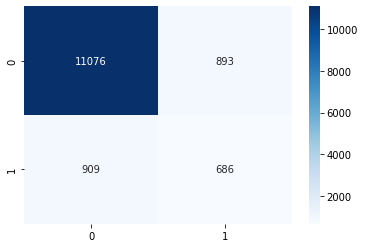

In [58]:
# Visualize the performance of RF-tuned 
# Plot confusion matrix
cf_matrix = confusion_matrix(y_test,y_pred_rfc_tuned)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

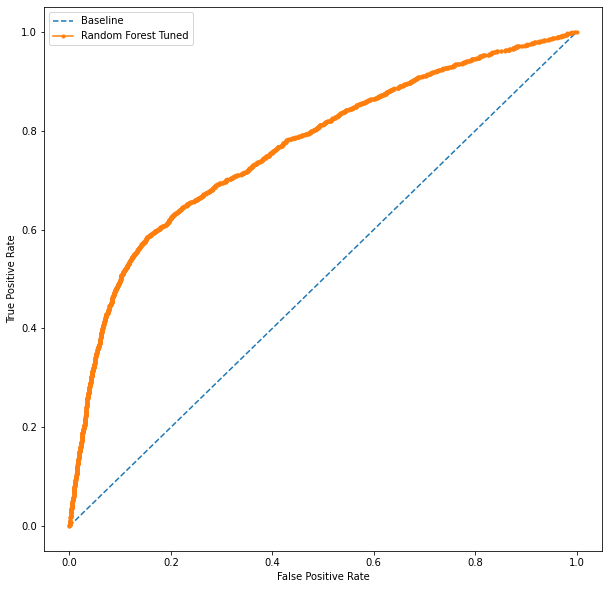

In [73]:
from sklearn.metrics import roc_curve
base_probs = [0 for _ in range(len(y_test))]
rfc_probs = rfc_tuned.predict_proba(X_test)[:,1]

# calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, rfc_probs)
# plot the roc curve for the model
plt.figure(figsize=(10,10))
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='Random Forest Tuned')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [67]:
# Plot feature importance
importances = rfc_tuned.feature_importances_
imp_std = np.std([tree.feature_importances_ for tree in rfc_tuned.estimators_], axis=0)
df_imp = pd.DataFrame({'feature': os_data_X.columns, 'importance': importances, 'std': imp_std})
df_imp = df_imp.sort_values('importance')
print(df_imp)

                feature  importance       std
31            month_dec    0.000313  0.000293
24          default_yes    0.000672  0.000620
23           default_no    0.001083  0.000801
14          job_student    0.001536  0.000715
16       job_unemployed    0.001567  0.000638
40            month_sep    0.001630  0.001516
8      job_entrepreneur    0.002344  0.000932
12    job_self-employed    0.002377  0.000832
11          job_retired    0.002530  0.000996
9         job_housemaid    0.002679  0.001147
39            month_oct    0.003717  0.002184
36            month_mar    0.004895  0.001967
17     marital_divorced    0.005613  0.001396
13         job_services    0.005849  0.001179
32            month_feb    0.006399  0.001901
6            job_admin.    0.006633  0.001175
33            month_jan    0.006857  0.002053
27              loan_no    0.007613  0.002689
20    education_primary    0.008241  0.001728
19       marital_single    0.008599  0.002190
10       job_management    0.00910

The five most important features are: campaign(how many times the client was contacted during this campaign), day(when the client was contacted), balance, previous(previous contacts), and age.

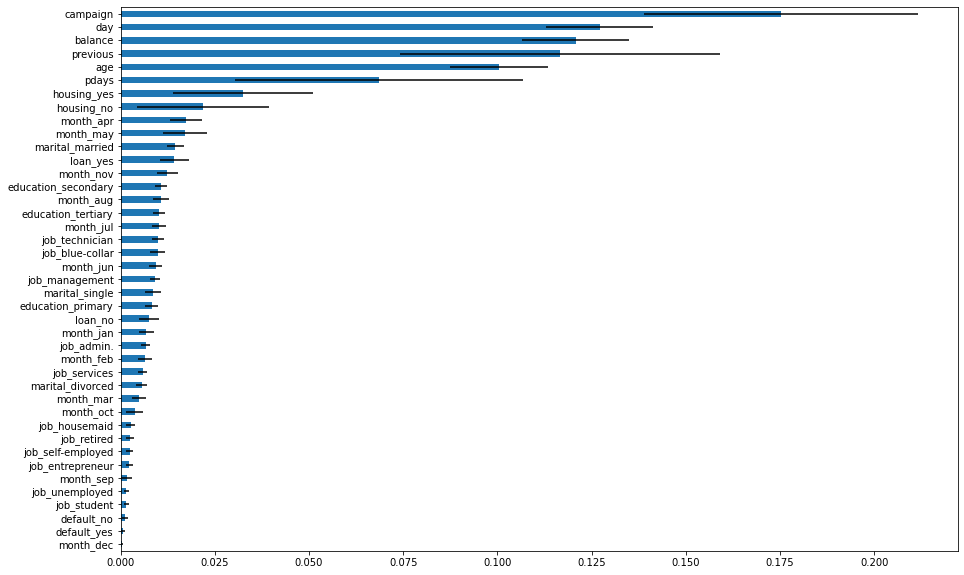

In [70]:
ax = df_imp.plot(kind='barh', xerr='std', x='feature', legend=False, figsize=(15,10))
ax.set_ylabel('')
plt.show()

All in all, we are choosing Random Forest (tuned) classifier as our final model.

# Appendix: PCA 

Try PCA to reduce dimension. Although PCA is designed for continuous variables and may not work well on binary data (which a lot of the variables in our dataset are), we'll try it anyways.

In [42]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)

In [43]:
#Principal Components Weights (Eigenvectors)
df_pca_weights = pd.DataFrame(pca.components_)
df_pca_weights.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,0.025342,0.003625,0.010594,0.027324,-0.019901,-0.029692,-0.047572,-0.180803,0.002408,0.015890,0.194165,0.035295,0.013388,-0.053845,0.011465,0.001512,0.008097,0.002666,-0.049324,0.046657,-0.019837,-0.266593,0.286430,0.000411,-0.000411,0.549334,-0.549334,0.041668,-0.041668,-0.014452,0.174349,0.004089,0.024155,0.015692,0.040262,0.046444,0.009648,-0.344433,0.019086,0.013834,0.011326
1,-0.056587,0.001367,-0.002634,-0.020738,0.018082,0.058268,-0.056647,-0.123248,0.004565,-0.018004,0.347406,-0.049544,0.009323,-0.052689,0.003838,-0.055801,-0.009200,0.028928,-0.292638,0.263710,-0.025707,-0.472295,0.498002,0.003856,-0.003856,-0.291897,0.291897,0.067407,-0.067407,0.010645,-0.048256,-0.001195,-0.003052,-0.002916,-0.071800,-0.057073,0.001246,0.162373,0.012421,-0.002283,-0.000110
2,-0.086433,-0.001709,-0.006231,-0.033266,0.006078,0.022431,0.096390,-0.125961,-0.017467,-0.017269,-0.139854,-0.028261,-0.006175,0.053266,0.046691,0.130766,0.007875,0.088095,-0.630155,0.542060,-0.214507,0.366689,-0.152182,-0.002236,0.002236,0.092174,-0.092174,0.028287,-0.028287,0.002409,-0.017743,0.001569,0.018751,0.014588,-0.014453,-0.007204,0.003374,0.009225,-0.017685,0.003694,0.003476
3,-0.012005,-0.003498,0.034662,0.014079,-0.014485,-0.046499,0.045292,-0.201053,0.020480,-0.012818,0.096549,-0.022483,0.003234,0.034912,-0.019040,0.067425,-0.012498,0.033618,-0.002578,-0.031040,-0.177155,0.055121,0.122034,-0.021008,0.021008,-0.070393,0.070393,-0.626796,0.626796,-0.007972,-0.046994,-0.002530,-0.004441,0.001189,0.241385,-0.039584,-0.004449,-0.159164,0.036770,-0.007200,-0.007009
4,-0.009626,-0.003017,-0.013946,-0.000431,-0.021286,-0.095826,-0.086436,0.501698,-0.004759,0.026206,-0.176824,0.018825,-0.007335,-0.057255,0.011727,-0.228040,0.002194,0.041330,-0.254231,0.212901,0.502386,-0.334803,-0.167584,-0.012388,0.012388,0.096731,-0.096731,-0.212573,0.212573,-0.018880,-0.109460,-0.002074,-0.005675,-0.003370,0.087701,0.070187,-0.003251,0.043249,-0.050385,-0.003930,-0.004112


In [44]:
#The PCs are arranged in descending order of the variance(information) explained. We want to see how
#much of the total information is contributed by each PC, use explained_variance_ratio
pca.explained_variance_ratio_

array([1.56805808e-01, 1.15638540e-01, 1.05503621e-01, 7.14288112e-02,
       6.37823253e-02, 4.51293880e-02, 4.40547367e-02, 4.07499664e-02,
       3.92390070e-02, 3.38545778e-02, 3.28680287e-02, 2.90014802e-02,
       2.59120692e-02, 2.45161967e-02, 2.09089070e-02, 2.01631900e-02,
       1.81525710e-02, 1.59827205e-02, 1.41826915e-02, 1.18809927e-02,
       1.03573229e-02, 8.87730863e-03, 8.51433096e-03, 7.34564349e-03,
       6.83648534e-03, 6.67891677e-03, 5.58276090e-03, 4.47890097e-03,
       3.40719997e-03, 3.18239180e-03, 2.80041199e-03, 1.28076356e-03,
       7.17890407e-04, 1.84042890e-04, 3.09244929e-32, 4.51651209e-33,
       4.04861255e-33, 2.44541014e-33, 1.74078301e-33, 1.02948805e-33,
       7.18493740e-35])

In [45]:
# Print the Covariance Matrix
X_cov=X.astype(float)
cov_matrix = np.cov(X_pca.T)
print('Covariance Matrix \n', cov_matrix)

Covariance Matrix 
 [[ 6.19042678e-01  6.87596653e-18 -1.21134885e-16 ... -7.42010838e-33
   6.13981866e-33 -1.08373497e-34]
 [ 6.87596653e-18  4.56521301e-01  1.07333838e-16 ... -1.35446423e-33
   8.11369876e-33 -1.57559047e-34]
 [-1.21134885e-16  1.07333838e-16  4.16510363e-01 ...  3.98937154e-33
  -7.19000214e-33  7.55342823e-34]
 ...
 [-7.42010838e-33 -1.35446423e-33  3.98937154e-33 ...  6.86779908e-33
  -9.42890406e-36  1.32840941e-35]
 [ 6.13981866e-33  8.11369876e-33 -7.19000214e-33 ... -9.42890406e-36
   4.04455895e-33  2.77334370e-35]
 [-1.08373497e-34 -1.57559047e-34  7.55342823e-34 ...  1.32840941e-35
   2.77334370e-35  2.44576326e-34]]


In [46]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigenvectors \n', eig_vecs)
print('\n Eigenvalues \n', eig_vals)

Eigenvectors 
 [[ 1.00000000e+00 -4.23080747e-17 -5.98101517e-16 ...  2.02382660e-32
  -7.55698468e-33  1.29690536e-32]
 [ 0.00000000e+00  1.00000000e+00  1.17682901e-15 ...  2.89640667e-27
  -1.08157715e-27  1.85613351e-27]
 [ 0.00000000e+00  1.37097622e-15 -1.00000000e+00 ...  1.44103598e-27
  -5.38090462e-28  9.23490108e-28]
 ...
 [ 0.00000000e+00  1.65364980e-32 -3.22849286e-32 ...  1.64283241e-01
  -9.57300029e-01  2.05072461e-01]
 [ 0.00000000e+00  7.20240579e-33  3.30761428e-32 ... -1.32248195e-01
   9.59530577e-02 -8.24014971e-02]
 [ 0.00000000e+00 -2.84772440e-34 -2.28832352e-33 ...  2.65095905e-02
   9.50287139e-03 -1.03391584e-02]]

 Eigenvalues 
 [6.19042678e-01 4.56521301e-01 4.16510363e-01 2.81988805e-01
 2.51801779e-01 1.78163153e-01 1.73920612e-01 1.60873941e-01
 1.54908930e-01 1.33652119e-01 1.29757390e-01 1.14492914e-01
 1.02296445e-01 9.67857774e-02 8.25448108e-02 7.96008469e-02
 7.16632650e-02 6.30970641e-02 5.59908552e-02 4.69041398e-02
 4.08889503e-02 3.50461055e-

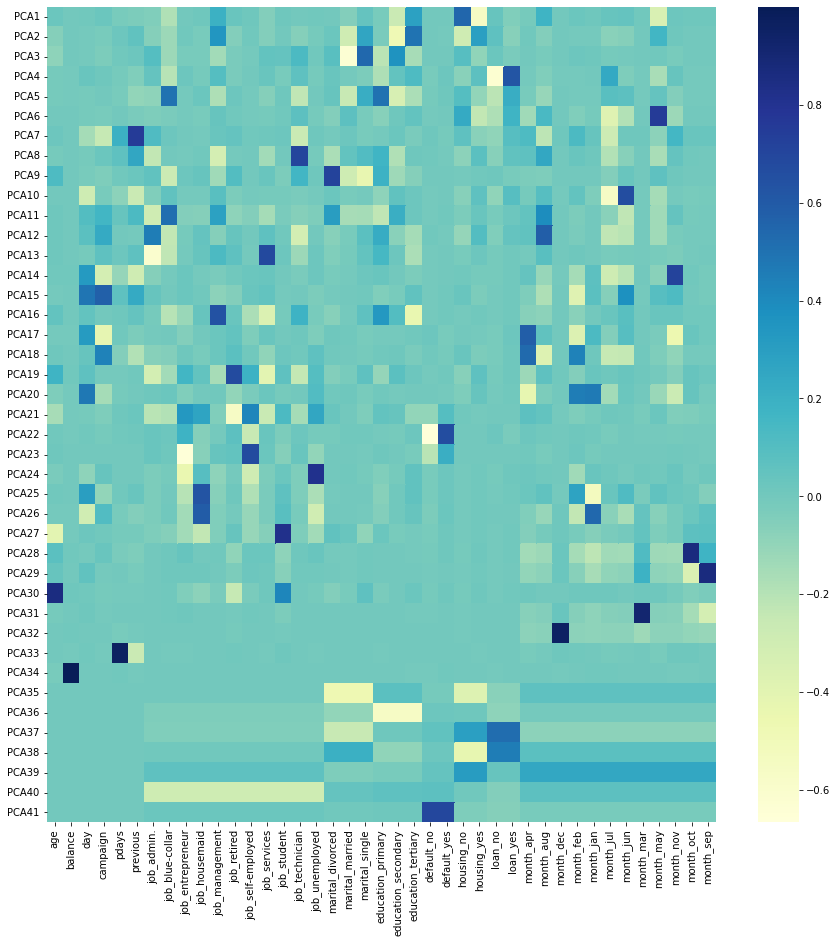

In [47]:
# Plot a  Heat map to check the effect of variables on each component.
# We can see influence on each of the PC by the features.
plt.figure(figsize=(15,15))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns))

Building Model Using PCA components that explain 95% variance of the data

In [48]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [49]:
# This leaves us with 23 PCs
X_pca.shape

(45211, 23)

For PCA we will not use SMOTE since it doesn't really make sense to us on synthetic points. Instead, we will do cross-validation on the entire dataset and use weighted F-1, recall, and precision as performance metrics. (Alternative strategy: use RandomOversampler from imblearn to create copies and then do PCA - we don't like creating copies so we will stick to the previous one)

Check the fundamental models first before do parameter tuning. Only check logistic regression, naive bayes and decision tree first.

In [60]:
# Initialize the models.
dt_pca=DecisionTreeClassifier(criterion='entropy',random_state=0)

LR_pca=LogisticRegression()

nb_pca=GaussianNB()

#rfc_pca=RandomForestClassifier(n_estimators=100,random_state=0)

#knn_pca=KNeighborsClassifier()

In [61]:
models_pca=[]
models_pca.append(('Logistic',LR_pca))
models_pca.append(('Decision Tree',dt_pca))
models_pca.append(('Naive Bayes',nb_pca))
#models_pca.append(('Random Forest',rfc_pca))
#models_pca.append(('KNN',knn_pca))

In [65]:
accuracy_pca=[]
auroc_pca=[]
f1_score_pca=[]
precision_pca=[]
recall_pca=[]
names_pca=[]

for name, model in models_pca:
    kfold = KFold(shuffle=True,n_splits=10,random_state=0)
    
    acc = cross_val_score(model,X_pca,y,cv=kfold,scoring='accuracy')
    accuracy_pca.append(np.mean(acc))

    roc_val = cross_val_score(model,X_pca,y, cv=kfold, scoring='roc_auc')
    auroc_pca.append(np.mean(roc_val))
    
    f1=cross_val_score(model,X_pca,y,cv=kfold,scoring='f1_weighted')
    f1_score_pca.append(np.mean(f1))
    
    prec = cross_val_score(model,X_pca,y,cv=kfold,scoring='precision_weighted')
    precision_pca.append(np.mean(prec))
    
    rec = cross_val_score(model,X_pca,y,cv=kfold,scoring='recall_weighted')
    recall_pca.append(np.mean(rec))
    
    names_pca.append(name)
    
result_pca_df=pd.DataFrame({'Model':names_pca,
                        'Accuracy Score':accuracy_pca,
                        'ROC-AUC Score':auroc_pca,
                        'F1 Score':f1_score_pca,
                        'Precision Score':precision_pca,
                        'Recall Score':recall_pca})

result_pca_df

,Model,Accuracy Score,ROC-AUC Score,F1 Score,Precision Score,Recall Score
0,Logistic,0.882838,0.719493,0.832810,0.837940,0.882838
1,Decision Tree,0.826016,0.593671,0.828477,0.831092,0.826016
2,Naive Bayes,0.827741,0.692941,0.830111,0.832641,0.827741


It seems like the accuracy increased significantly for logistic and naive bayes model, but decreased for decision tree. For all three models. the AUROC scores all decreased significantly. This might suggest that the model doesn't separate 0 and 1 class well (although it's imbalanced dataset). Considering the fact that PCA takes away explainability and we only have a few continuous numerical variables in our predictors, we will stop here. For future improvement, we might consider doing other types of preprocessing to both use PCA and account for the imbalanced issue.